In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb

from sklearn.feature_selection import SelectKBest, mutual_info_classif


# Reading and Preprocessing the Training Data
stroke_data = pd.read_csv("data/stroke_train_set.csv")

In [5]:
stroke_data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,47.0,0,0,Yes,Private,Urban,63.98,26.8,smokes,0
1,Male,54.0,0,0,Yes,Private,Urban,86.26,35.1,formerly smoked,0
2,Female,3.0,0,0,No,children,Rural,68.34,18.0,Unknown,0
3,Female,62.0,0,0,Yes,Private,Rural,226.38,47.4,never smoked,0
4,Female,27.0,0,0,Yes,Private,Rural,85.60,21.4,Unknown,0
5,Male,39.0,0,0,Yes,Private,Urban,164.67,33.8,Unknown,0
6,Female,47.0,0,0,Yes,Private,Rural,195.04,45.5,never smoked,0
7,Male,1.8,0,0,No,children,Urban,153.31,17.1,Unknown,0
8,Male,41.0,0,0,Yes,Private,Urban,104.34,30.3,Unknown,0
9,Female,47.0,0,0,Yes,Private,Urban,68.48,21.3,never smoked,0


In [6]:
# Check dataset info - field types, non-null values, dtypes
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                3926 non-null   float64
 9   smoking_status     4088 non-null   object 
 10  stroke             4088 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 351.4+ KB


In [7]:
# percentage of missing values for each column in the dataset.
missing_values_percentage = stroke_data.isnull().mean() * 100
missing_values_percentage

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.962818
smoking_status       0.000000
stroke               0.000000
dtype: float64

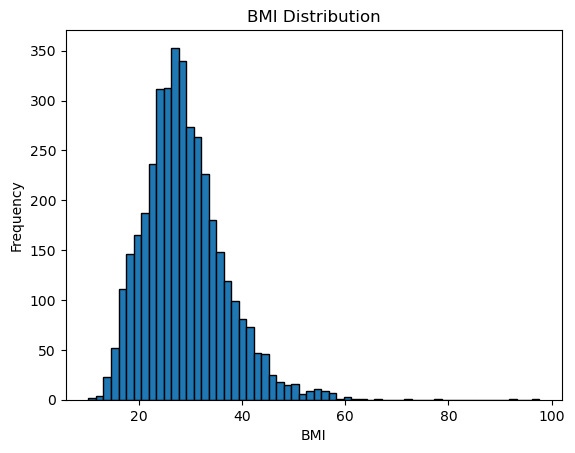

In [8]:
# cheking the distribution of bmi
stroke_data['bmi'].plot(kind='hist', bins=60, edgecolor='black')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Imputing missing values
def impute_missing_values(df):
    bmi_median = df['bmi'].median()
    df['bmi'].fillna(bmi_median, inplace=True)
    return df
stroke_data_imputed = impute_missing_values(stroke_data)

In [10]:
# Removing duplicate rows
def remove_duplicates(df):
    return df.drop_duplicates()
stroke_data_imputed_no_duplicates = remove_duplicates(stroke_data_imputed)

In [11]:
# Encoding data
def encode_data(df):
    df_encoded = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'])
    df_encoded['ever_married'] = df_encoded['ever_married'].map({'Yes': 1, 'No': 0})
    df_encoded['Residence_type'] = df_encoded['Residence_type'].map({'Urban': 1, 'Rural': 0})
    return df_encoded
stroke_data_encoded = encode_data(stroke_data_imputed_no_duplicates)

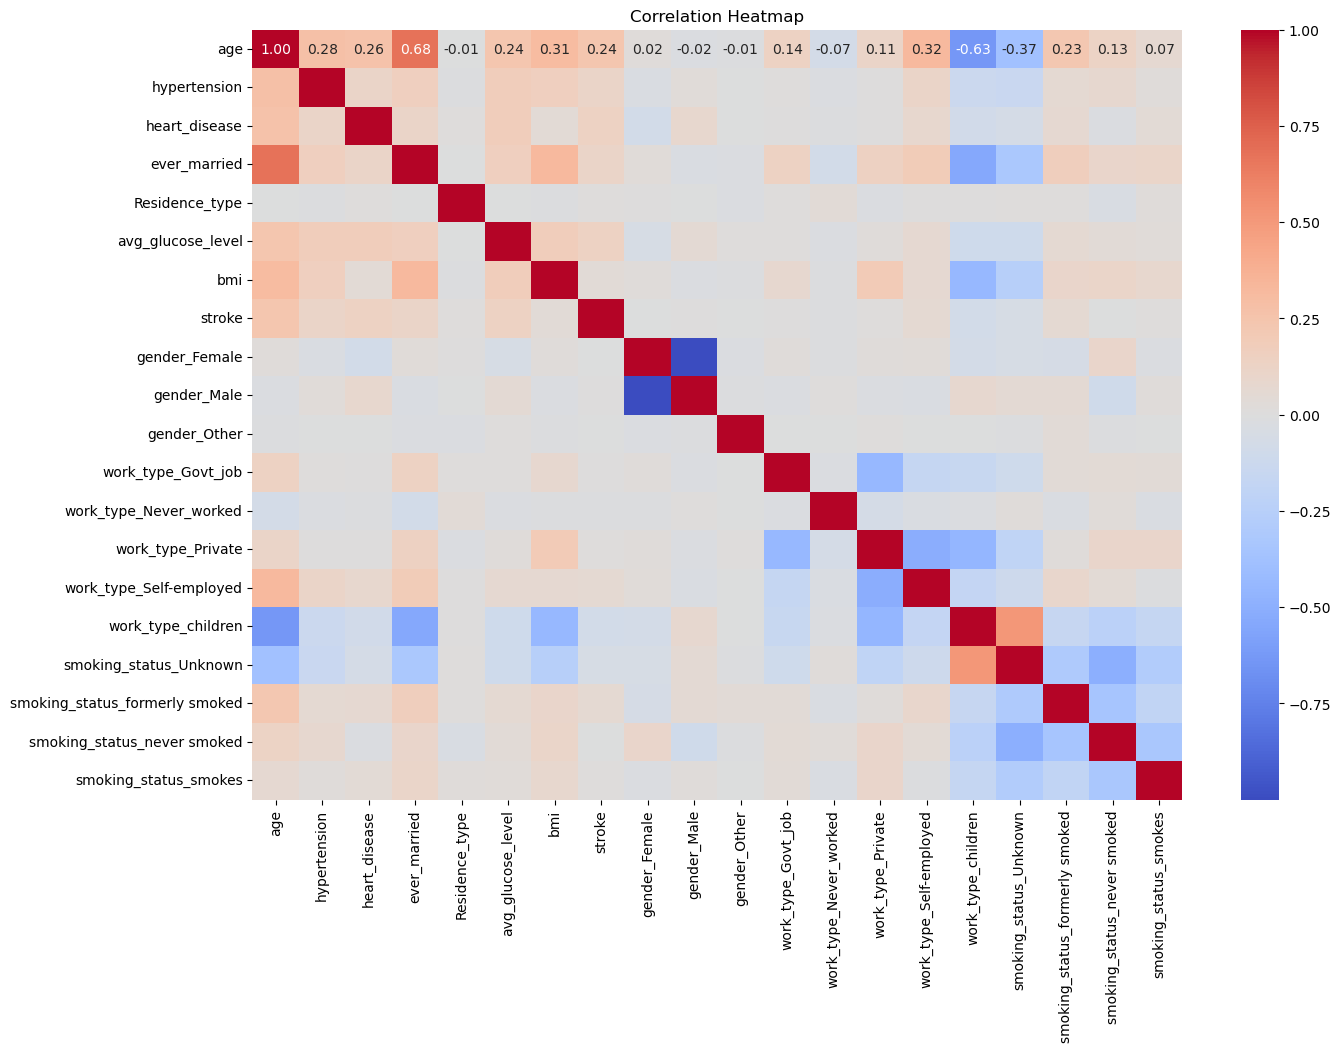

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(stroke_data_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

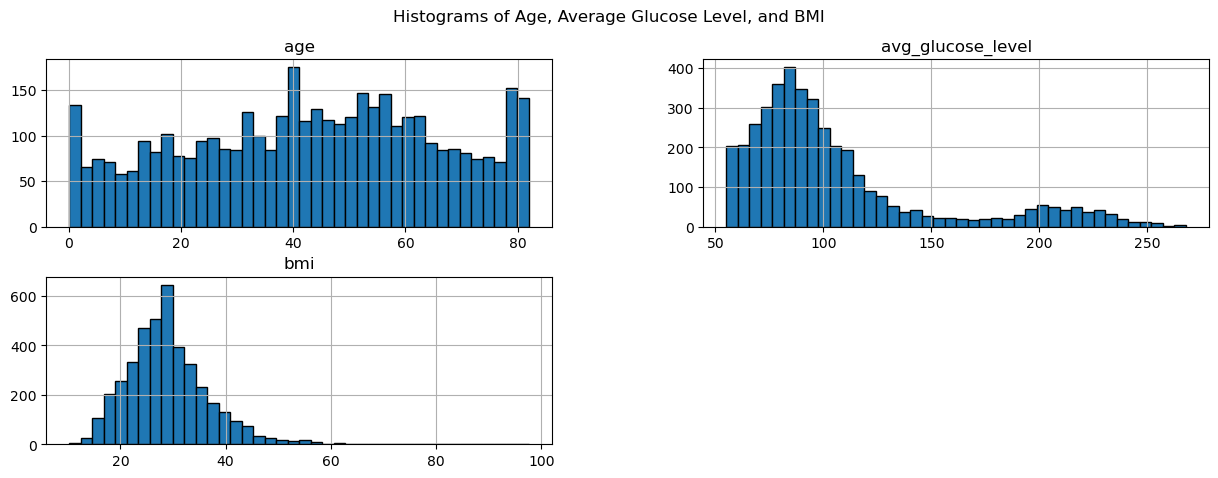

In [13]:
# Creating histograms for continuous variables using Pandas
stroke_data_encoded[['age', 'avg_glucose_level', 'bmi']].hist(bins=40, edgecolor='black', figsize=(15, 5))
plt.suptitle('Histograms of Age, Average Glucose Level, and BMI')
plt.show()

/Users/vivekagarwal/miniconda3/envs/mlenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vivekagarwal/miniconda3/envs/mlenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


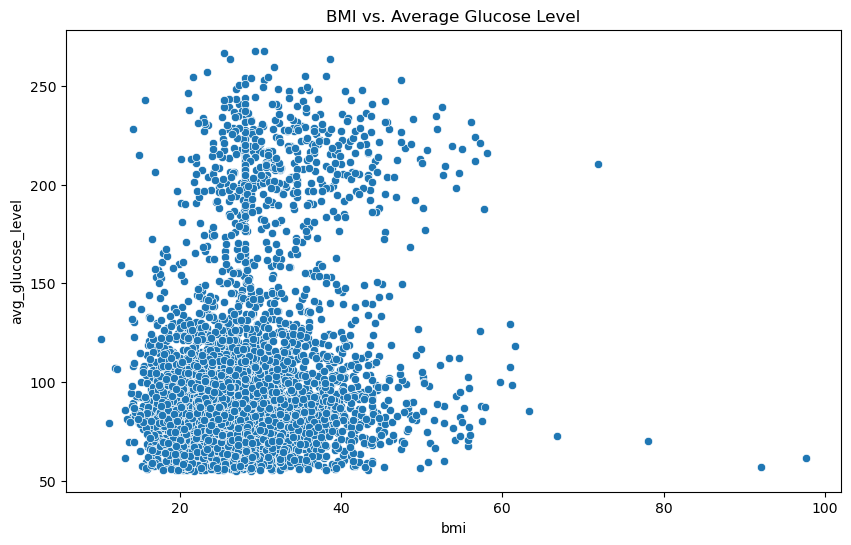

In [14]:
# Scatter Plot: BMI vs. Average Glucose Level
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stroke_data_encoded['bmi'], y=stroke_data_encoded['avg_glucose_level'])
plt.title('BMI vs. Average Glucose Level')
plt.show()

In [15]:
# dropping stroke column
X, y = stroke_data_encoded.drop(columns=['stroke']), stroke_data_encoded['stroke']

In [16]:
# Selecting features
def select_features(X, y):
    feat_selector = SelectKBest(mutual_info_classif, k=12)
    X_selected_features = feat_selector.fit_transform(X, y)
    chosen_features = feat_selector.get_feature_names_out()
    return X[chosen_features], chosen_features
X_selected, chosen_features = select_features(X, y)

In [17]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [18]:
# Resampling and scaling
def resample_and_scale(X, y):
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_resampled)
    return X_scaled, y_resampled, scaler
X_train_scaled, y_train_resampled, scaler = resample_and_scale(X_train, y_train)

In [19]:
# Model Training
model = SVC(class_weight='balanced')
model.fit(X_train_scaled, y_train_resampled)

SVC(class_weight='balanced')

In [20]:
# Model Evaluation
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

In [21]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)

# Outputting the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8092909535452323
Precision: 0.9313080493517575
Recall: 0.8092909535452323
F1 Score: 0.859406018668804
Confusion Matrix:
 [[965 205]
 [ 29  28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      1170
           1       0.12      0.49      0.19        57

    accuracy                           0.81      1227
   macro avg       0.55      0.66      0.54      1227
weighted avg       0.93      0.81      0.86      1227



In [22]:
# Preparing Test Data for Submission
test_data = pd.read_csv('data/stroke_test_set_nogt.csv')
test_data_imputed = impute_missing_values(test_data)
test_data_encoded = encode_data(test_data_imputed)
test_data_chosen = test_data_encoded[chosen_features]
test_data_scaled = scaler.transform(test_data_chosen)

# Making predictions for submission
test_predictions = model.predict(test_data_scaled)

# Creating Submission File
submission = pd.DataFrame({'ID': test_data.index, 'stroke': test_predictions})
submission.to_csv('stroke_prediction_submission.csv', index=False)